<h1> <center> Calculo de la masa de una galaxia conociendo únicamente su curva de rotación </center></h1>
<h2> <center> Santiago Lastra Ramírez </center></h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import scipy.special as sp
from lmfit.models import ExpressionModel
import scipy.integrate as integrate
#plt.style.use('classic')

In [2]:
# Datos
GAL=pd.read_csv("NGC2403.dat",sep="   ",names=["R","V"],skiprows=[0,1,2,3,4,5,6,7,8,9,10,11])
GAL.R=GAL.R
Vc=GAL.V/(3.1e16)

# Constantes 
G=6.674e-11*(1.989*10**30)/(3.1e19)**3

/home/santiago/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


## Funciones

In [3]:
def Hernquist_Vc( r, a, rho_0 ):
    Vc2 = 2*a*r*np.pi*G*rho_0/(1+r/a)**2
    return Vc2

def Exponential_Vc( r, Rd, Sigma_0 ):
    Vc2 = np.pi*G*Sigma_0*r*(r/Rd)*(sp.iv(0, r/(2*Rd))*sp.kv(0, r/(2*Rd))-sp.iv(1, r/(2*Rd))*sp.kv(1, r/(2*Rd)))
    return Vc2

def Galaxy_NB( r, a, rho0, Rd, Sigma0 ):
    VcH2 = 2*a*r*np.pi*G*rho0/(1+r/a)**2
    VcD2 = np.pi*G*Sigma0*r*(r/Rd)*(sp.iv(0, r/(2*Rd))*sp.kv(0, r/(2*Rd))-sp.iv(1, r/(2*Rd))*sp.kv(1, r/(2*Rd)))
    Vc2 = VcH2+VcD2
    return Vc2

## No bulge

### Hernquist

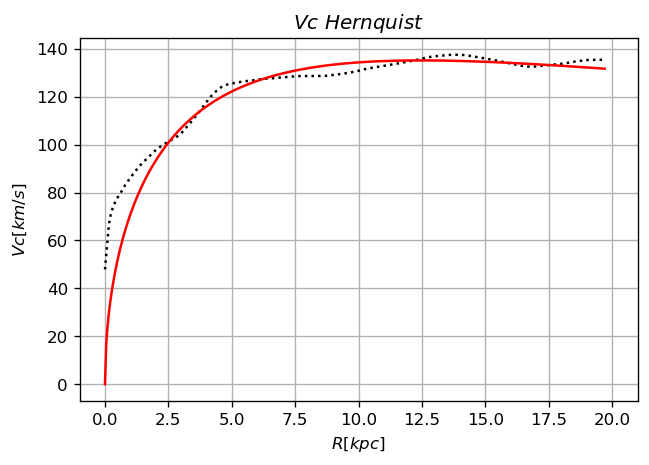

In [4]:
x=np.linspace(GAL.R[1],20,len(GAL.R))

poptH, pcovH = curve_fit(Hernquist_Vc, x,Vc**2, p0=[13, 4e6])

M=np.format_float_scientific(2*poptH[0]**3*np.pi*poptH[1], precision = 2, exp_digits=2)
a=np.format_float_scientific(poptH[0], precision = 2, exp_digits=1)

plt.figure(dpi=120)
plt.plot(GAL.R,GAL.V,"k:")
plt.plot(GAL.R, np.sqrt(Hernquist_Vc(GAL.R, *poptH))*3.1e16,color="r",label=f"$M={M}$ $M_\odot$\n$a={a}$ kpc")
plt.title("$Vc$ $Hernquist$")
plt.ylabel("$Vc[km/s]$")
plt.xlabel("$R[kpc]$")
plt.xlim(-1,21)
#plt.ylim(-1,141)
plt.grid()
#plt.legend()
plt.show()

### Suma de funciones

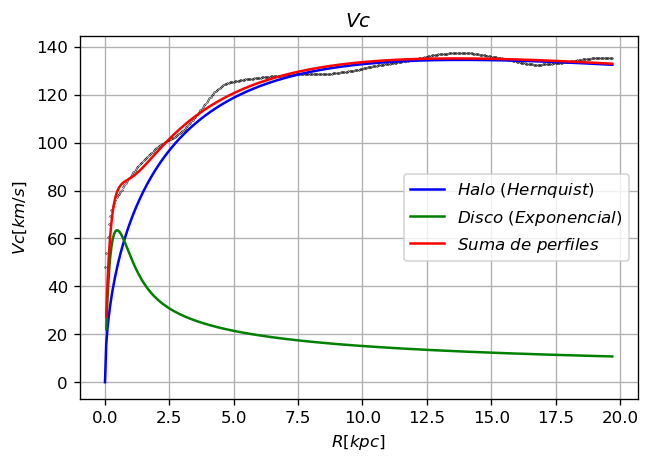

In [5]:
popt, pcov = curve_fit(Galaxy_NB, x,Vc**2,p0=[poptH[0], poptH[1], 2.0, 1.0E5])

M=np.format_float_scientific(2*popt[0]**3*np.pi*popt[1], precision = 2, exp_digits=2)
a=np.format_float_scientific(popt[0], precision = 2, exp_digits=1)
Sigma=np.format_float_scientific(popt[3], precision = 2, exp_digits=1)
Rd=np.format_float_scientific(popt[2], precision = 2, exp_digits=1)
Mdisco=np.format_float_scientific(popt[3]*np.pi*20**2, precision = 2, exp_digits=1)

plt.figure(dpi=120)

plt.plot(GAL.R,GAL.V,"ko",ms=0.3)
plt.plot(GAL.R, np.sqrt(Hernquist_Vc(GAL.R, popt[0],popt[1]))*3.1e16,"b",label="$Halo$ $(Hernquist)$")
plt.plot(GAL.R, np.sqrt(Exponential_Vc(GAL.R, popt[2],popt[3]))*3.1e16,"g",label="$Disco$ $(Exponencial)$")
plt.plot(GAL.R,np.sqrt(Galaxy_NB(GAL.R,*popt))*3.1e16,"r",label="$Suma$ $de$ $perfiles$")

plt.title("$Vc$")
plt.ylabel("$Vc[km/s]$")
plt.xlabel("$R[kpc]$")

plt.legend()
plt.grid()
#plt.savefig("NoBulge.png",dpi=400)
plt.show()

In [6]:
Vc2_H =  Hernquist_Vc( x, popt[0], popt[1] )
Vc2_D =  Exponential_Vc( x, popt[2], popt[3] )
Vc2_G = Galaxy_NB( x, popt[0], popt[1], popt[2], popt[3])

MasaGF = 1.0/G*integrate.simps(Vc2_G, x, dx=0.1, axis=-1, even='avg')
MasaD = 1.0/G*integrate.simps(Vc2_D, x, dx=0.1, axis=-1, even='avg')
MasaH = 1.0/G*integrate.simps(Vc2_H, x, dx=0.1, axis=-1, even='avg')

print ("Masa de NGC2403 (Ajuste) = %e M_sun" %(MasaGF))
print ("Masa del disco (Ajuste) = %e M_sun" %(MasaD))
print ("Masa del halo (Ajuste) = %e M_sun" %(MasaH))

Masa de NGC2403 (Ajuste) = 7.323559e+10 M_sun
Masa del disco (Ajuste) = 2.377102e+09 M_sun
Masa del halo (Ajuste) = 7.085849e+10 M_sun


## With Bulge

In [7]:
def Galaxy_B( r, a, rho0, Rd, Sigma0, aB, rho0B):
    VcH2 = 2*a*r*np.pi*G*rho0/(1+r/a)**2
    VcD2 = np.pi*G*Sigma0*r*(r/Rd)*(sp.iv(0, r/(2*Rd))
                                    *sp.kv(0, r/(2*Rd))-sp.iv(1, r/(2*Rd))*sp.kv(1, r/(2*Rd)))
    VcB2 = 15*aB*r*np.pi*G*rho0B/(1+r/aB)**2
    Vc2 = VcH2+VcD2+VcB2
    return Vc2

def Bulge( r, aB, rho0B):
    Vc2 = 15*aB*r*np.pi*G*rho0B/(1+r/aB)**2
    return Vc2

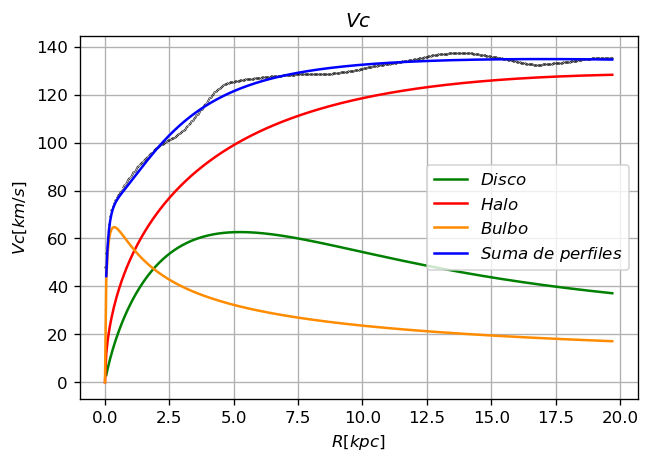

In [8]:
popt, pcov = curve_fit(Galaxy_B, x,Vc**2,p0=[15,1e8,5,6e8,1,1e8])

M=np.format_float_scientific(2*popt[0]**3*np.pi*popt[1], precision = 2, exp_digits=2)
a=np.format_float_scientific(popt[0], precision = 2, exp_digits=1)
Sigma=np.format_float_scientific(popt[3], precision = 2, exp_digits=1)
Rd=np.format_float_scientific(popt[2], precision = 2, exp_digits=1)
aB=np.format_float_scientific(popt[4], precision = 2, exp_digits=1)
MB=np.format_float_scientific(15*popt[4]**3*np.pi*popt[5], precision = 2, exp_digits=2)

plt.figure(dpi=120)

plt.plot(GAL.R,GAL.V,"ko",ms=0.3)
plt.plot(GAL.R, np.sqrt(Exponential_Vc(GAL.R, popt[2],popt[3]))*3.1e16,"g",label="$Disco$")
plt.plot(GAL.R, np.sqrt(Hernquist_Vc(GAL.R, popt[0],popt[1]))*3.1e16,"r",label="$Halo$")
plt.plot(GAL.R, np.sqrt(Bulge(GAL.R, popt[4],popt[5]))*3.1e16,color="darkorange",label="$Bulbo$")
plt.plot(GAL.R,np.sqrt(Galaxy_B(GAL.R,*popt))*3.1e16,"b",label="$Suma$ $de$ $perfiles$")

plt.title("$Vc$")
plt.ylabel("$Vc[km/s]$")
plt.xlabel("$R[kpc]$")

plt.legend()
plt.grid()
#plt.savefig("Bulge.png",dpi=400)
plt.show()

In [9]:
Vc2_H =  Hernquist_Vc( x, popt[0], popt[1] )
Vc2_D =  Exponential_Vc( x, popt[2], popt[3] )
Vc2_B =  Bulge(x, popt[4], popt[5])
Vc2_G =  Galaxy_B( x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])

MasaGF = 1.0/G*integrate.simps(Vc2_G, x, dx=0.1, axis=-1, even='avg')
MasaD = 1.0/G*integrate.simps(Vc2_D, x, dx=0.1, axis=-1, even='avg')
MasaB = 1.0/G*integrate.simps(Vc2_B, x, dx=0.1, axis=-1, even='avg')
MasaH = 1.0/G*integrate.simps(Vc2_H, x, dx=0.1, axis=-1, even='avg')

print ("Masa de NGC2403 (Ajuste) = %e M_sun" %(MasaGF))
print ("Masa del bulbo (Ajuste) = %e M_sun" %(MasaB))
print ("Masa del disco (Ajuste) = %e M_sun" %(MasaD))
print ("Masa del halo (Ajuste) = %e M_sun" %(MasaH))

Masa de NGC2403 (Ajuste) = 7.331309e+10 M_sun
Masa del bulbo (Ajuste) = 4.261281e+09 M_sun
Masa del disco (Ajuste) = 1.171258e+10 M_sun
Masa del halo (Ajuste) = 5.733923e+10 M_sun
